In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [198]:
data = pd.read_csv('internet_service_churn.csv')

In [199]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

print("Summary:")
print("Numerical variables plotted: ", list(numeric_columns))
print("Categorical variables plotted: ", list(categorical_columns))

Summary:
Numerical variables plotted:  ['id', 'is_tv_subscriber', 'is_movie_package_subscriber', 'subscription_age', 'bill_avg', 'reamining_contract', 'service_failure_count', 'download_avg', 'upload_avg', 'download_over_limit', 'churn']
Categorical variables plotted:  []


Тобто усі дані числові

In [200]:
data.head()


,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


In [201]:
df = data.copy()

print(df.shape)
print(df.isna().sum())#check Nan values




(72274, 11)
id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64


## Аналіз reamining_contract  

In [202]:
count_zero = (df["reamining_contract"] == 0.00).sum()
print(f'Count all "remaining_contract" equal to 0.00:" {count_zero}')

#change all '0.00' to NaN
if "reamining_contract" in df.columns:
    df["reamining_contract"] = df["reamining_contract"].replace(0.00, np.nan)

#Filter where churn == 1
churn_1_rows = df[df["churn"] == 1]
    
total_churn_1 = len(churn_1_rows)
    
remaining_contract_nan = churn_1_rows["reamining_contract"].isna().sum()
    

percentage = (remaining_contract_nan / total_churn_1) * 100
print(f"Percentage where churn == 1 and remaining_contract == NaN: {percentage:.2f}%")


Count all "remaining_contract" equal to 0.00:" 16363
Percentage where churn == 1 and remaining_contract == NaN: 89.91%


Можна зробити висновок, що в 90% випадків якщо колонка "churn" (дані про відток) = 1, reamining_contract буде 0,00 або NaN. З цього приводу мені здається що reamining_contract можна видалити. Також колонка id не носить корисної для нас інформації  

In [203]:
columns_to_drop = ["reamining_contract", "id"]
df = df.drop(columns=columns_to_drop, errors='ignore')
print(df.shape)
print(df.isna().sum())

(72274, 9)
is_tv_subscriber                 0
is_movie_package_subscriber      0
subscription_age                 0
bill_avg                         0
service_failure_count            0
download_avg                   381
upload_avg                     381
download_over_limit              0
churn                            0
dtype: int64


## Аналіз download_avg та upload_avg  

In [204]:
filtered_row_nan = df[df["download_avg"].isna() | df["upload_avg"].isna()]
print(len(filtered_row_nan))

percentage_nan = (len(filtered_row_nan) / len(df)) * 100

print(f'Percentage of rows where download_avg or upload_avg is NaN: {percentage_nan:.2f}%')

381
Percentage of rows where download_avg or upload_avg is NaN: 0.53%


Висновок: Через незначний відсоток (0.53%) рядків де download_avg або upload_avg == NaN мені здається доцільніше буде іх видалити ніж замінювати

In [205]:

df = df.dropna(subset=["download_avg", "upload_avg"])
print(df.isna().sum())

df.shape

is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
dtype: int64


(71893, 9)

## Аналіз bill_avg

In [206]:
scaler = MinMaxScaler()

df['bill_avg_normalized'] = scaler.fit_transform(df[['bill_avg']])
df.insert(3, 'bill_avg_normalized', df.pop('bill_avg_normalized'))

print(df[['bill_avg', 'bill_avg_normalized']].head())

df = df.drop('bill_avg', axis=1)

   bill_avg  bill_avg_normalized
0        25             0.061576
1         0             0.000000
2        16             0.039409
3        21             0.051724
4         0             0.000000


В колонці 'bill_avg' знаходяться дані про грошове значення (грн,$,£...ми не знаємо). Мені здається доцільно стандартизувати значення. Для цього використав MinMaxScaler -> стандартизація в діапазоні віз 0 до 1

## Аналіз кореляцій

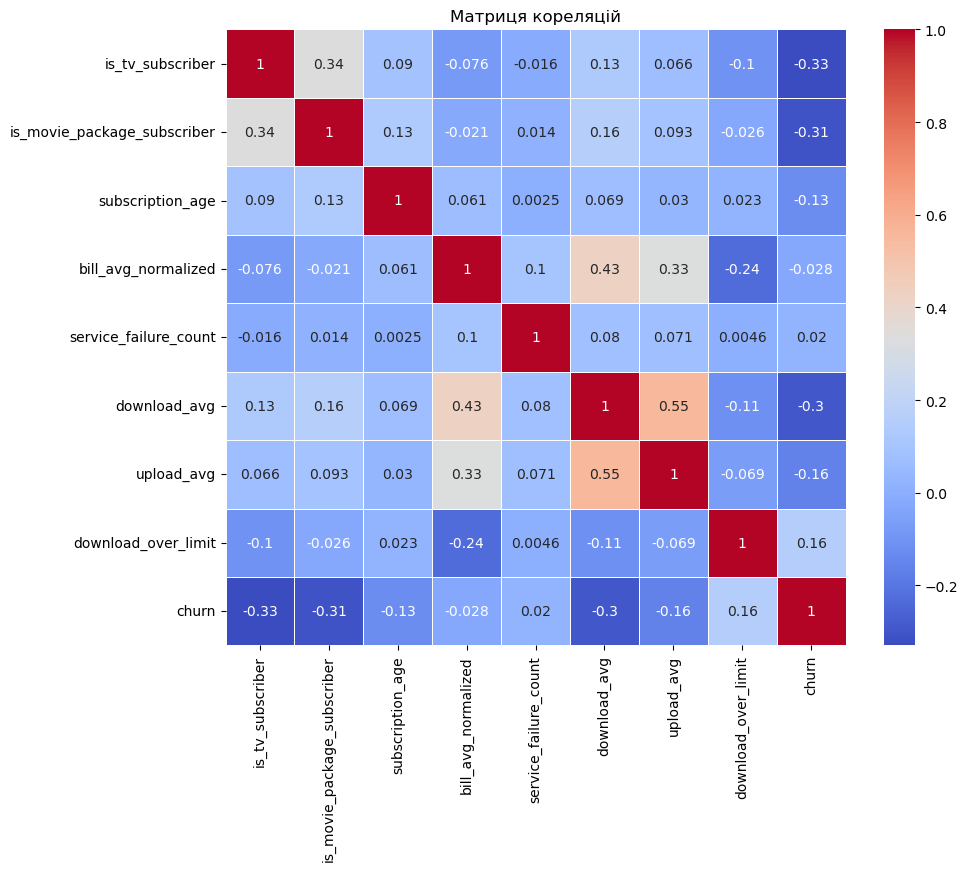

In [207]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Матриця кореляцій")
plt.show()